In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'

batch_size_train = 64  
batch_size_test = 64   

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=batch_size_train,
    class_mode='binary'  
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(64, 64),
    batch_size=batch_size_test,
    class_mode='binary'  
)

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 9386 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(BatchNormalization())


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  

model.add(Dense(1, activation='sigmoid'))  

model.summary()

Metal device set to: Apple M2 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxP

2023-09-11 17:30:50.806540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-11 17:30:50.806683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,  
    loss='binary_crossentropy',  
    metrics=['accuracy']  
)


Epoch 1/10


2023-09-11 17:30:51.073846: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-11 17:30:51.294434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8919

2023-09-11 17:31:10.196742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - 21s 140ms/step - loss: 0.2672 - accuracy: 0.8919 - val_loss: 0.6353 - val_accuracy: 0.7003
Epoch 2/10
147/147 [==============================] - 20s 139ms/step - loss: 0.1092 - accuracy: 0.9595 - val_loss: 0.4848 - val_accuracy: 0.9103
Epoch 3/10
147/147 [==============================] - 20s 138ms/step - loss: 0.0864 - accuracy: 0.9665 - val_loss: 0.3183 - val_accuracy: 0.9135
Epoch 4/10
147/147 [==============================] - 20s 138ms/step - loss: 0.0751 - accuracy: 0.9688 - val_loss: 0.2505 - val_accuracy: 0.8942
Epoch 5/10
147/147 [==============================] - 21s 140ms/step - loss: 0.0641 - accuracy: 0.9732 - val_loss: 0.2230 - val_accuracy: 0.9119
Epoch 6/10
147/147 [==============================] - 21s 144ms/step - loss: 0.0589 - accuracy: 0.9759 - val_loss: 0.5050 - val_accuracy: 0.8125
Epoch 7/10
147/147 [==============================] - 20s 139ms/step - loss: 0.0532 - accuracy: 0.9785 - val_loss: 0.5646 - val_accuracy: 0.8

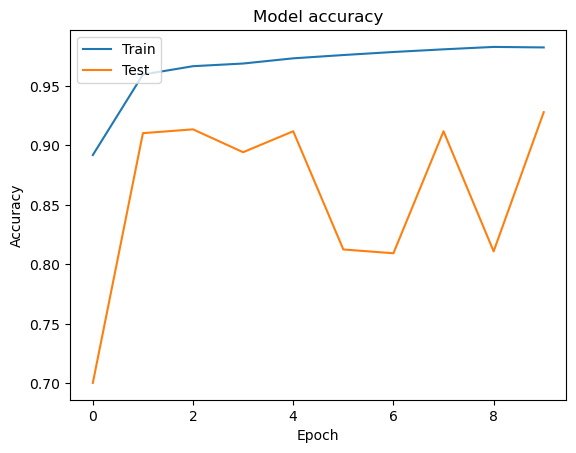

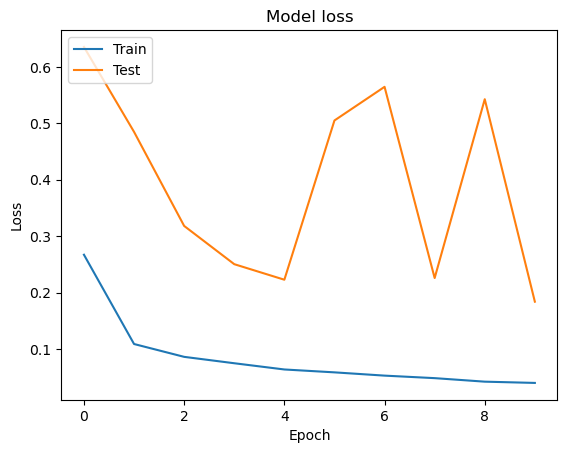

In [4]:
# Train the model

from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,  
    epochs=10,         
    batch_size=batch_size_train,  
    validation_data=test_generator, 
    callbacks=[early_stopping]
    
)

# Plot the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
